In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

In [2]:
skin_df = pd.read_csv("archive\HAM10000_metadata.csv")
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
imageid_path_dict = {}
for i in range (10015):
    imageid_path_dict["ISIC_00" + str(24306+i)] = "archive\HAM10000_images\ISIC_00"+ str(24306+i)+".jpg"

In [3]:
skin_df["path"] = skin_df["image_id"].map(imageid_path_dict.get)
skin_df["cell_type"] = skin_df["dx"].map(lesion_type_dict.get)
skin_df["cell_type_idx"] = pd.Categorical(skin_df["cell_type"]).codes

In [4]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [5]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [6]:
skin_df["age"].fillna(np.mean(skin_df["age"]), inplace = True)

In [7]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [8]:
skin_df["image"] = skin_df["path"].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [9]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [10]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [11]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 1234)

In [13]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test["image"].tolist())

In [17]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [18]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [19]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [20]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [25]:
input_shape = (75,100,3)
num_classes = 7
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation = "relu", input_shape=input_shape, padding = "same"))
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.40))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 75, 100, 32)       896       
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 50, 64)        36928     
                                                      

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,)

In [27]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [28]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [29]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator( featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)
datagen.fit(x_train)

In [30]:
epochs = 64
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

C:\Users\Acer\AppData\Local\Temp\ipykernel_44108\3088845468.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/64
675/675 [==============================] - 132s 194ms/step - loss: 1.0505 - accuracy: 0.6665 - val_loss: 0.9225 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 2/64
675/675 [==============================] - 124s 184ms/step - loss: 0.9709 - accuracy: 0.6694 - val_loss: 0.9286 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 3/64
675/675 [==============================] - 122s 181ms/step - loss: 0.9452 - accuracy: 0.6699 - val_loss: 0.9066 - val_accuracy: 0.6755 - lr: 0.0010
Epoch 4/64
675/675 [==============================] - 121s 179ms/step - loss: 0.9024 - accuracy: 0.6725 - val_loss: 0.8735 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 5/64
675/675 [==============================] - 124s 184ms/step - loss: 0.8824 - accuracy: 0.6773 - val_loss: 0.8327 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 6/64
675/675 [==============================] - 120s 178ms/step - loss: 0.8639 - accuracy: 0.6828 - val_loss: 0.8302 - val_accuracy: 0.6888 - lr: 0.0010
Epoch 7/64
675/675 [==========================

675/675 [==============================] - 134s 199ms/step - loss: 0.7562 - accuracy: 0.7243 - val_loss: 0.7121 - val_accuracy: 0.7301 - lr: 0.0010
Epoch 22/64
675/675 [==============================] - 124s 183ms/step - loss: 0.7613 - accuracy: 0.7234 - val_loss: 0.7249 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 23/64
675/675 [==============================] - 127s 188ms/step - loss: 0.7578 - accuracy: 0.7204 - val_loss: 0.7781 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 24/64
675/675 [==============================] - 123s 182ms/step - loss: 0.7479 - accuracy: 0.7262 - val_loss: 0.7552 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 25/64
675/675 [==============================] - 125s 185ms/step - loss: 0.7496 - accuracy: 0.7186 - val_loss: 0.7169 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 26/64
675/675 [==============================] - 124s 184ms/step - loss: 0.7500 - accuracy: 0.7208 - val_loss: 0.7048 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 27/64
675/675 [==============================]

675/675 [==============================] - 119s 176ms/step - loss: 0.7296 - accuracy: 0.7363 - val_loss: 0.7570 - val_accuracy: 0.7247 - lr: 0.0010
Epoch 42/64
675/675 [==============================] - 124s 183ms/step - loss: 0.7337 - accuracy: 0.7283 - val_loss: 0.7550 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 43/64
675/675 [==============================] - 122s 180ms/step - loss: 0.7364 - accuracy: 0.7262 - val_loss: 0.7424 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 44/64
675/675 [==============================] - 122s 180ms/step - loss: 0.7131 - accuracy: 0.7294 - val_loss: 0.7218 - val_accuracy: 0.7221 - lr: 0.0010
Epoch 45/64
675/675 [==============================] - 121s 180ms/step - loss: 0.7271 - accuracy: 0.7379 - val_loss: 0.7260 - val_accuracy: 0.7301 - lr: 0.0010
Epoch 46/64
675/675 [==============================] - 122s 181ms/step - loss: 0.7266 - accuracy: 0.7327 - val_loss: 0.6965 - val_accuracy: 0.7434 - lr: 0.0010
Epoch 47/64
675/675 [==============================]

675/675 [==============================] - 129s 191ms/step - loss: 0.7131 - accuracy: 0.7400 - val_loss: 0.7513 - val_accuracy: 0.7327 - lr: 0.0010
Epoch 62/64
675/675 [==============================] - 129s 191ms/step - loss: 0.7103 - accuracy: 0.7361 - val_loss: 0.7283 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 63/64
675/675 [==============================] - 126s 186ms/step - loss: 0.7166 - accuracy: 0.7392 - val_loss: 0.6963 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 64/64
675/675 [==============================] - 130s 192ms/step - loss: 0.7191 - accuracy: 0.7403 - val_loss: 0.7435 - val_accuracy: 0.7327 - lr: 0.0010


In [31]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

24/24 [==============================] - 1s 57ms/step - loss: 0.7435 - accuracy: 0.7327
Validation: accuracy = 0.732713  ;  loss_v = 0.743482
Test: accuracy = 0.749201  ;  loss = 0.699060


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict(x_validate)
Y_true = np.argmax(y_validate,axis = 1)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
confusion_matrix  = confusion_matrix(Y_true, Y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = range(7))

24/24 [==============================] - 1s 56ms/step


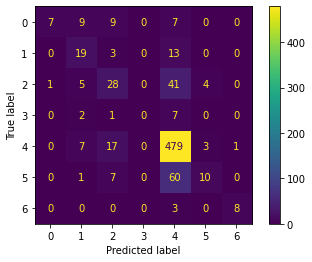

In [38]:
cm_display.plot()
plt.show()

In [121]:
from keras.applications.vgg16 import decode_predictions
def predict_image(path):
    fileImage = Image.open(path).convert("RGB").resize((100,75), Image.ANTIALIAS)
    label = [1]

    img = np.array(fileImage)
    plt.imshow(img)
    plt.show()
    
    lesion_type_dict = ['Melanocytic nevi',
                        'Melanoma',
                        'Benign keratosis-like lesions '
                        ,'Basal cell carcinoma',
                        'Actinic keratoses',
                        'Vascular lesions',
                        'Dermatofibroma']
    
    img = img.reshape(1, *(75, 100, 3))
    img = img / 255.
    predicted_image = model.predict(img)
    disase = lesion_type_dict[np.argmax(predicted_image)]
    print(disase)
    predicted_image = np.squeeze(predicted_image)
    predicted_image[::-1].sort()
    print(predicted_image[0])

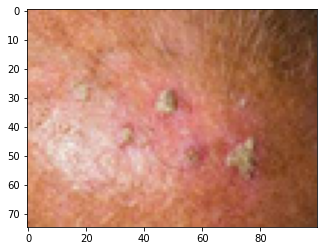

1/1 [==============================] - 0s 20ms/step
Actinic keratoses
0.4717903


In [122]:
predict_image("test1.jpg")